In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Feature Enhancement using Fuzzy 

Enhanced X shape: (1200, 28, 28)
y shape: (1200,)


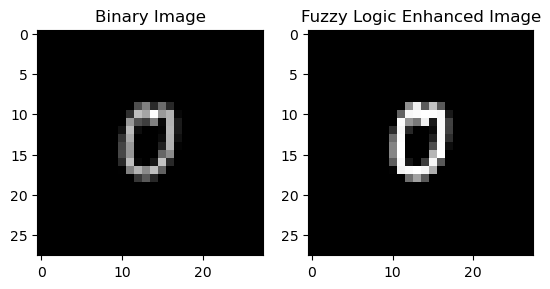

In [9]:
# Load the binary samples and classes
binary_samples = np.load('digits_x.npy')
classes = np.load('digits_y.npy')

# Apply fuzzy logic enhancement
def apply_fuzzy_logic(image):
    # Define fuzzy sets for brightness
    brightness = ctrl.Antecedent(np.arange(0, 256, 1), 'brightness')
    brightness['dark'] = fuzz.trimf(brightness.universe, [0, 0, 128])
    brightness['medium'] = fuzz.trimf(brightness.universe, [0, 128, 255])
    brightness['bright'] = fuzz.trimf(brightness.universe, [128, 255, 255])

    # Define fuzzy sets for edge strength
    edge_strength = ctrl.Antecedent(np.arange(0, 256, 1), 'edge_strength')
    edge_strength['weak'] = fuzz.trimf(edge_strength.universe, [0, 0, 128])
    edge_strength['moderate'] = fuzz.trimf(edge_strength.universe, [0, 128, 255])
    edge_strength['strong'] = fuzz.trimf(edge_strength.universe, [128, 255, 255])

    # Define the output fuzzy set for character presence
    character_presence = ctrl.Consequent(np.arange(0, 256, 1), 'character_presence')
    character_presence['absent'] = fuzz.trimf(character_presence.universe, [0, 0, 128])
    character_presence['present'] = fuzz.trimf(character_presence.universe, [128, 255, 255])

    # Define fuzzy rules
    rule1 = ctrl.Rule(brightness['dark'] & edge_strength['weak'], character_presence['absent'])
    rule2 = ctrl.Rule(brightness['dark'] & edge_strength['moderate'], character_presence['absent'])
    rule3 = ctrl.Rule(brightness['dark'] & edge_strength['strong'], character_presence['present'])
    rule4 = ctrl.Rule(brightness['medium'] & edge_strength['weak'], character_presence['absent'])
    rule5 = ctrl.Rule(brightness['medium'] & edge_strength['moderate'], character_presence['present'])
    rule6 = ctrl.Rule(brightness['medium'] & edge_strength['strong'], character_presence['present'])
    rule7 = ctrl.Rule(brightness['bright'] & edge_strength['weak'], character_presence['present'])
    rule8 = ctrl.Rule(brightness['bright'] & edge_strength['moderate'], character_presence['present'])
    rule9 = ctrl.Rule(brightness['bright'] & edge_strength['strong'], character_presence['present'])

    # Create the control system
    character_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
    character_detect = ctrl.ControlSystemSimulation(character_ctrl)

    # Apply fuzzy logic to each pixel
    height, width = image.shape
    result = np.zeros((height, width), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            pixel_value = image[i, j]
            character_detect.input['brightness'] = pixel_value
            character_detect.input['edge_strength'] = pixel_value  # Simplified edge strength
            character_detect.compute()
            result[i, j] = character_detect.output['character_presence']

    return result

# Apply fuzzy logic enhancement to all binary samples
enhanced_samples = np.array([apply_fuzzy_logic(image) for image in binary_samples])

# Save the enhanced samples
enhanced_xfile = 'enhanced_digits_x.npy'
np.save(enhanced_xfile, enhanced_samples)

print(f'Enhanced X shape: {enhanced_samples.shape}')
print(f'y shape: {classes.shape}')

# Display an example image before and after fuzzy logic enhancement
plt.subplot(1, 2, 1)
plt.title('Binary Image')
plt.imshow(binary_samples[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Fuzzy Logic Enhanced Image')
plt.imshow(enhanced_samples[0], cmap='gray')
plt.show()


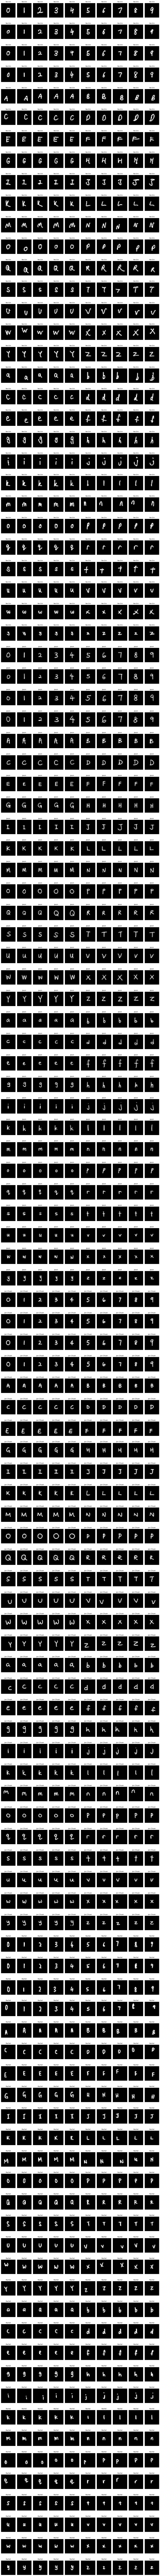

In [10]:
# Load the enhanced samples and classes from .npy files
enhanced_samples = np.load('enhanced_digits_x.npy')
classes = np.load('digits_y.npy')

# Number of images to display
num_images = enhanced_samples.shape[0]

# Number of columns and rows for the grid
num_cols = 10
num_rows = (num_images + num_cols - 1) // num_cols  

# Create a figure for the grid with larger size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2))

# Loop through all the images and display them in the grid
for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        ax.imshow(enhanced_samples[i], cmap='gray')
        ax.set_title(class_labels[classes[i]], fontsize=10)  
        ax.axis('off')
        ax.set_aspect('equal')  
    else:
        fig.delaxes(ax)

plt.tight_layout()  
plt.show()


### Neural Network no flatten

In [11]:
# Load the preprocessed samples and classes from .npy files
binary_samples = np.load('enhanced_digits_x.npy')
classes = np.load('digits_y.npy')

# Reshape the binary_samples to include the channel dimension (grayscale)
binary_samples = binary_samples.reshape(binary_samples.shape[0], 28, 28, 1)

# Normalize the image data
binary_samples = binary_samples.astype('float32') / 255.0

# Convert class labels to one-hot encoding
num_classes = 4
classes = to_categorical(classes, num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_samples, classes, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Define the CNN model architecture
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=16)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

X_train shape: (960, 28, 28, 1)
y_train shape: (960, 4)
X_test shape: (240, 28, 28, 1)
y_test shape: (240, 4)
Epoch 1/50
48/48 [==============================] - 3s 25ms/step - loss: 1.2853 - accuracy: 0.4427 - val_loss: 1.3594 - val_accuracy: 0.2292
Epoch 2/50
48/48 [==============================] - 1s 19ms/step - loss: 0.9524 - accuracy: 0.6159 - val_loss: 1.3473 - val_accuracy: 0.2344
Epoch 3/50
48/48 [==============================] - 1s 20ms/step - loss: 0.7533 - accuracy: 0.7318 - val_loss: 1.3464 - val_accuracy: 0.2604
Epoch 4/50
48/48 [==============================] - 1s 20ms/step - loss: 0.6019 - accuracy: 0.7852 - val_loss: 1.3228 - val_accuracy: 0.2708
Epoch 5/50
48/48 [==============================] - 1s 19ms/step - loss: 0.4375 - accuracy: 0.8685 - val_loss: 1.2085 - val_accuracy: 0.3177
Epoch 6/50
48/48 [==============================] - 1s 17ms/step - loss: 0.4108 - accuracy: 0.8633 - val_loss: 1.2274 - val_accuracy: 0.4531
Epoch 7/50
48/48 [==========================

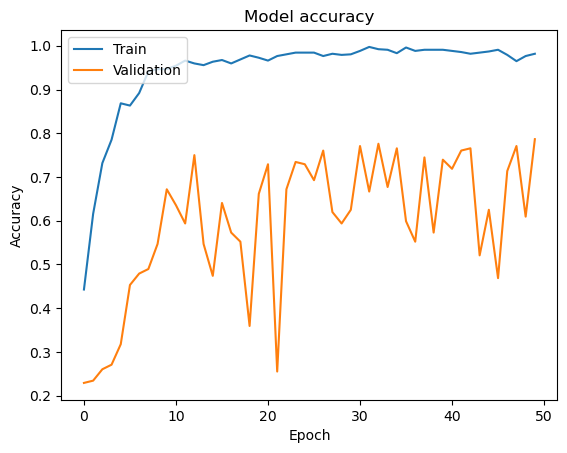

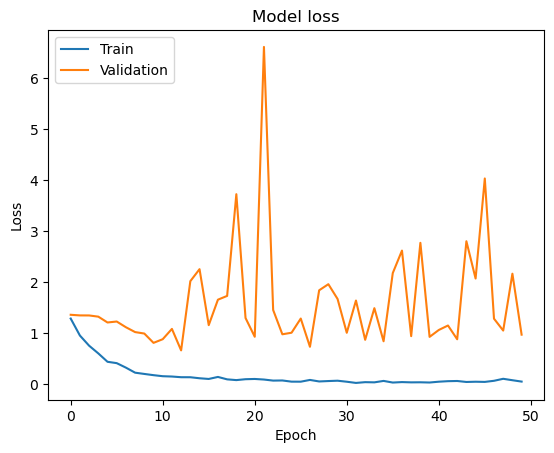

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [13]:
# Get the predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_test back to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_labels, y_pred, target_names=["Yee Ern", "Jason", "Jun Chuan", "Rachel"])

# Print the classification report
print(report)




8/8 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

     Yee Ern       0.68      0.65      0.66        62
       Jason       0.96      0.73      0.83        60
   Jun Chuan       0.75      0.68      0.71        60
      Rachel       0.60      0.83      0.70        58

    accuracy                           0.72       240
   macro avg       0.74      0.72      0.73       240
weighted avg       0.75      0.72      0.72       240



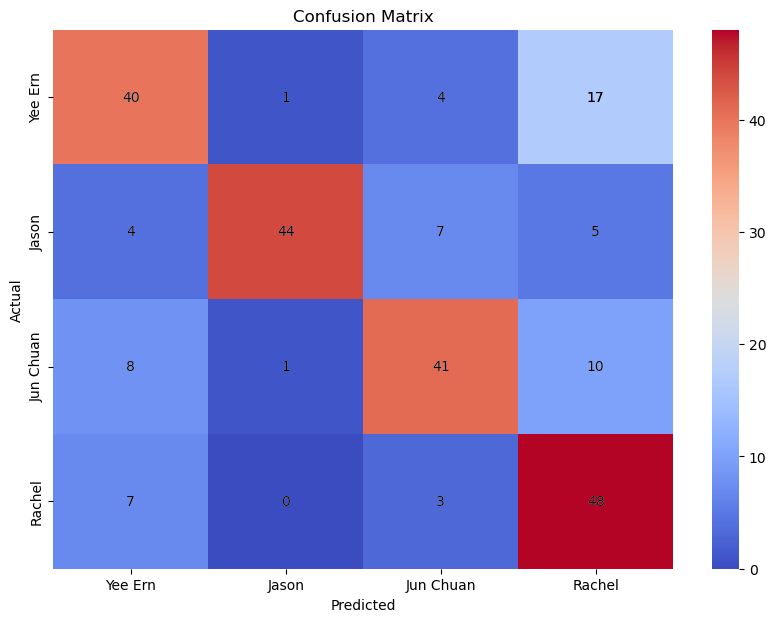

In [14]:
cm = confusion_matrix(y_test_labels, y_pred)

# Visualize Confusion Matrix with cell-wise labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Add cell-wise labels
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j + 0.5, i + 0.5, cm[i, j], ha='center', va='center', color='Black')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Assuming y_pred is already in label format
y_pred = np.argmax(model.predict(X_test), axis=1)

# Convert y_test from one-hot encoded format to label format
y_test_labels = np.argmax(y_test, axis=1)

# Find correct and incorrect predictions
correct_indices = np.where(y_pred == y_test_labels)[0]
incorrect_indices = np.where(y_pred != y_test_labels)[0]

print("Correct predictions:", len(correct_indices))
print("Incorrect predictions:", len(incorrect_indices))


8/8 [==============================] - 0s 10ms/step
Correct predictions: 173
Incorrect predictions: 67


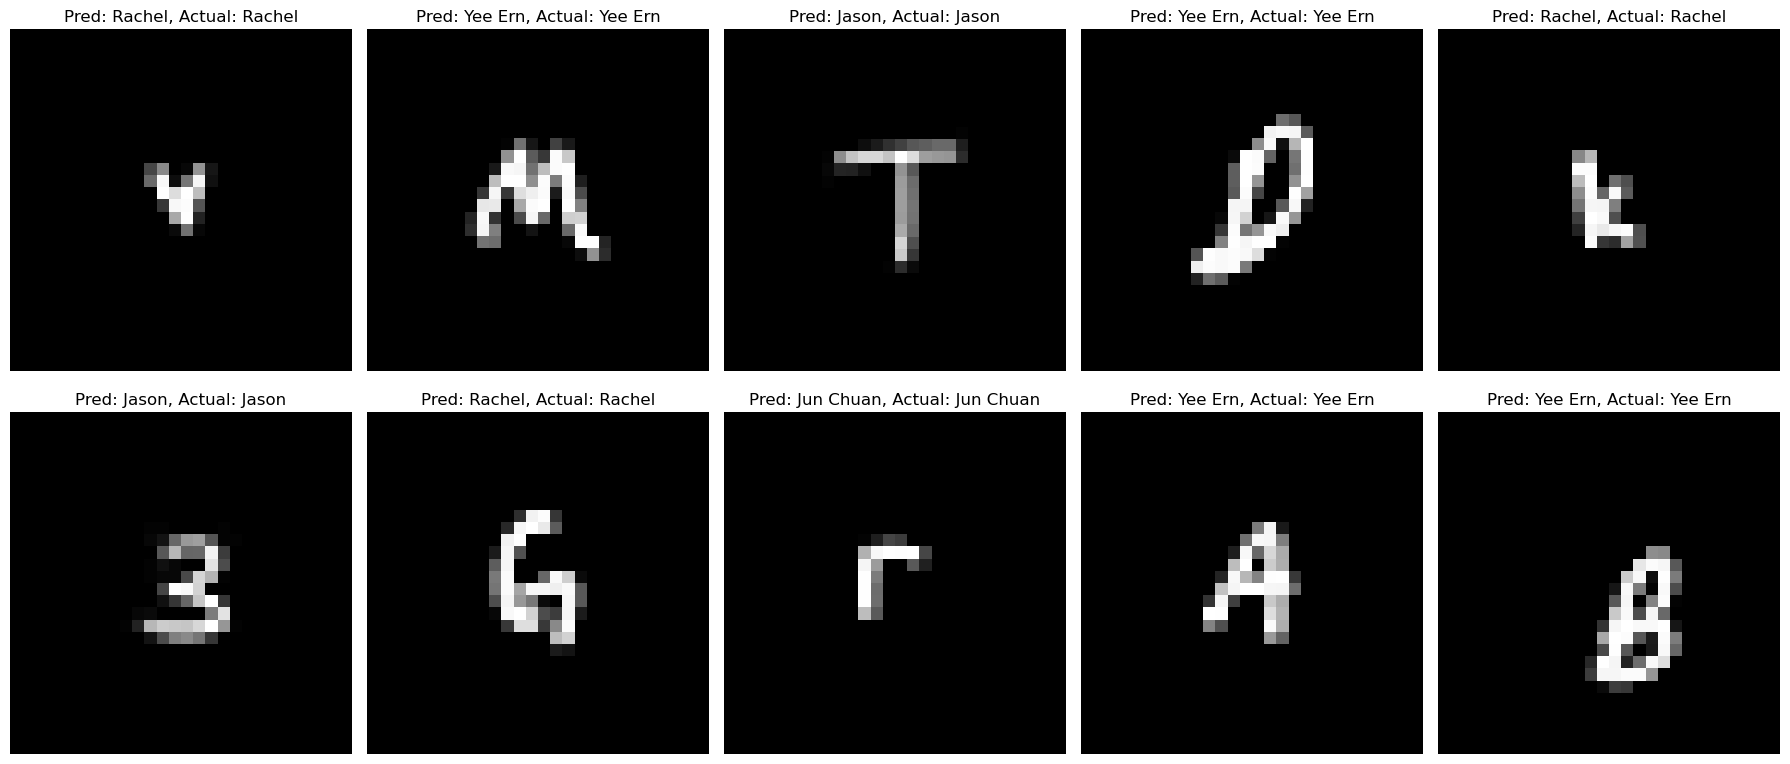

In [17]:
index_to_class = {i: class_label for i, class_label in enumerate(class_labels)}

# Convert y_test from one-hot encoded format to label format
y_test_labels = np.argmax(y_test, axis=1)

# Assuming X_images contains the original images corresponding to fuzzy_features
X_images_train, X_images_test, _, _ = train_test_split(binary_samples, classes, test_size=0.2, random_state=42)

# Display 10 examples of correct predictions
plt.figure(figsize=(18, 8))
for i, correct in enumerate(correct_indices[:10]):
    plt.subplot(2, 5, i+1)  # Adjusting subplot layout for 10 samples
    plt.imshow(X_images_test[correct], cmap='gray')
    plt.title(f"Pred: {index_to_class[y_pred[correct]]}, Actual: {index_to_class[y_test_labels[correct]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

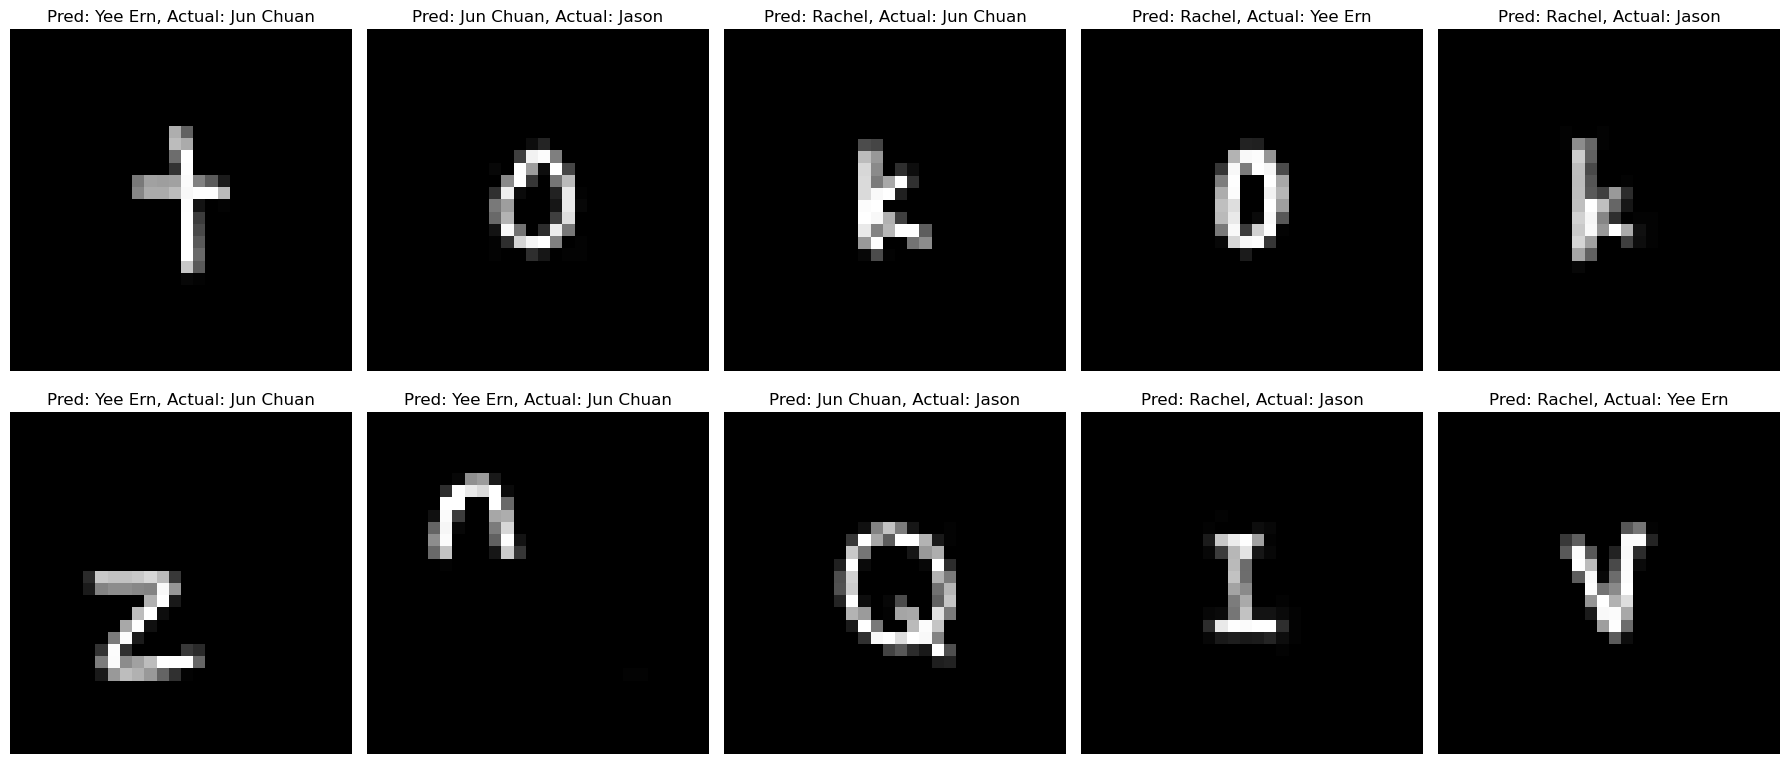

In [18]:
# Assuming X_images_test contains the original images
plt.figure(figsize=(18, 8))
for i, incorrect in enumerate(incorrect_indices[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_images_test[incorrect], cmap='gray')
    plt.title(f"Pred: {index_to_class[y_pred[incorrect]]}, Actual: {index_to_class[y_test_labels[incorrect]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Genetic Algorithm

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms
import random

In [20]:
# Load the preprocessed samples and classes from .npy files
binary_samples = np.load('enhanced_digits_x.npy')
classes = np.load('digits_y.npy')

# Reshape the binary_samples to include the channel dimension (grayscale)
binary_samples = binary_samples.reshape(binary_samples.shape[0], 28, 28, 1)

# Normalize the image data
binary_samples = binary_samples.astype('float32') / 255.0

# Convert class labels to one-hot encoding
num_classes = 4
classes = to_categorical(classes, num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_samples, classes, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (960, 28, 28, 1)
y_train shape: (960, 4)
X_test shape: (240, 28, 28, 1)
y_test shape: (240, 4)


In [21]:
def build_model(params):
    conv1_filters, conv2_filters, dense_units, dropout_rate = params
    model = Sequential()
    model.add(Conv2D(conv1_filters, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(conv2_filters, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(params):
    model = build_model(params)
    model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=16, verbose=0)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy,


In [22]:
# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_conv1", random.randint, 16, 64)
toolbox.register("attr_conv2", random.randint, 32, 128)
toolbox.register("attr_dense", random.randint, 64, 256)
toolbox.register("attr_dropout", random.uniform, 0.2, 0.5)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_conv1, toolbox.attr_conv2, toolbox.attr_dense, toolbox.attr_dropout), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)

def mutate(individual):
    # Mutate integer attributes
    if random.random() < 0.2:
        individual[0] = random.randint(16, 64)
    if random.random() < 0.2:
        individual[1] = random.randint(32, 128)
    if random.random() < 0.2:
        individual[2] = random.randint(64, 256)
    # Mutate float attribute
    if random.random() < 0.2:
        individual[3] = random.uniform(0.2, 0.5)
    return individual,

toolbox.register("mutate", mutate)
toolbox.register("select", tools.selRoulette)
toolbox.register("evaluate", evaluate_model)


In [23]:
def main():
    random.seed(42)
    pop = toolbox.population(n=10)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                       stats=stats, halloffame=hof, verbose=True)

    return pop, logbook, hof

pop, logbook, hof = main()

# Best individual
best_params = hof[0]
print("Best parameters found:", best_params)

gen	nevals	avg   	std      	min     	max     
0  	10    	0.5675	0.0869786	0.454167	0.679167
1  	10    	0.558333	0.111009 	0.3     	0.7125  
2  	8     	0.552083	0.110401 	0.341667	0.720833
3  	8     	0.5375  	0.0959782	0.383333	0.6875  
4  	7     	0.495417	0.0992411	0.35    	0.658333
5  	7     	0.4975  	0.15096  	0.258333	0.7625  
6  	5     	0.487917	0.11226  	0.258333	0.658333
7  	8     	0.570417	0.0924296	0.4     	0.6875  
8  	8     	0.498333	0.110369 	0.329167	0.679167
9  	7     	0.484583	0.0859597	0.358333	0.608333
10 	6     	0.555   	0.134071 	0.2625  	0.720833
Best parameters found: [31.572010551289075, 116.18244261317729, 165.06045566160216, 0.29894359585949226]


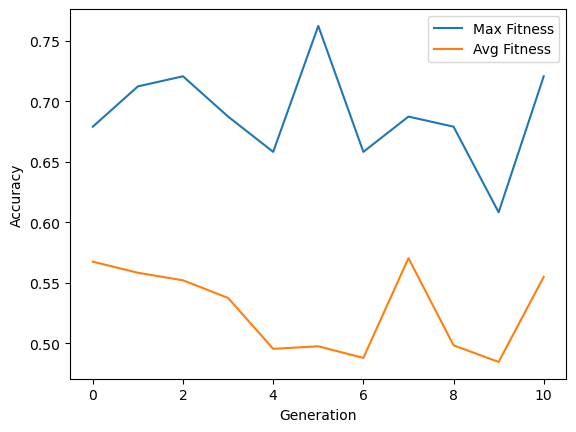

In [24]:
gen = logbook.select("gen")
fit_max = logbook.select("max")
fit_avg = logbook.select("avg")

plt.plot(gen, fit_max, label='Max Fitness')
plt.plot(gen, fit_avg, label='Avg Fitness')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
best_params = [31, 60, 73, 0.48716392166203437]
# Build and train the best model using the optimized parameters
best_model = build_model(best_params)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=16)

# Evaluate the best model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('Test accuracy of the best model:', test_acc)


Epoch 1/50
48/48 [==============================] - 3s 31ms/step - loss: 1.2889 - accuracy: 0.4180 - val_loss: 1.3707 - val_accuracy: 0.2240
Epoch 2/50
48/48 [==============================] - 1s 28ms/step - loss: 1.0764 - accuracy: 0.5508 - val_loss: 1.3553 - val_accuracy: 0.2812
Epoch 3/50
48/48 [==============================] - 2s 32ms/step - loss: 0.9597 - accuracy: 0.6445 - val_loss: 1.3097 - val_accuracy: 0.3594
Epoch 4/50
48/48 [==============================] - 1s 29ms/step - loss: 0.8299 - accuracy: 0.6745 - val_loss: 1.2709 - val_accuracy: 0.5208
Epoch 5/50
48/48 [==============================] - 1s 29ms/step - loss: 0.7285 - accuracy: 0.7370 - val_loss: 1.2145 - val_accuracy: 0.5104
Epoch 6/50
48/48 [==============================] - 1s 21ms/step - loss: 0.6800 - accuracy: 0.7578 - val_loss: 1.3032 - val_accuracy: 0.4010
Epoch 7/50
48/48 [==============================] - 1s 22ms/step - loss: 0.5569 - accuracy: 0.8125 - val_loss: 1.0758 - val_accuracy: 0.5312
Epoch 8/50
48

8/8 [==============================] - 0s 11ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        62
           1       0.96      0.78      0.86        60
           2       0.61      0.85      0.71        60
           3       0.76      0.43      0.55        58

    accuracy                           0.72       240
   macro avg       0.75      0.71      0.71       240
weighted avg       0.75      0.72      0.71       240



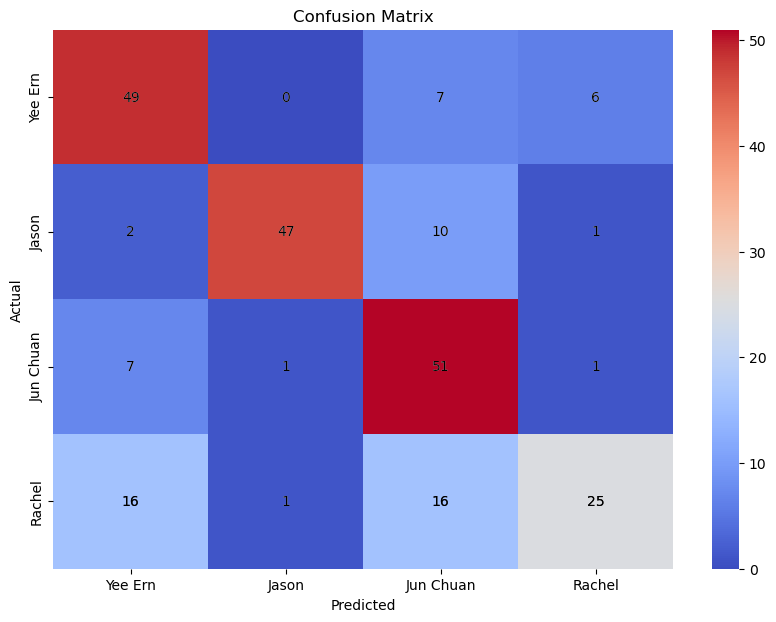

In [26]:

# Generate predictions on the test set
y_pred = np.argmax(best_model.predict(X_test), axis=1)

# Convert y_test from one-hot encoded format to label format
y_test_labels = np.argmax(y_test, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))

# Construct confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Visualize Confusion Matrix with cell-wise labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Add cell-wise labels
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j + 0.5, i + 0.5, cm[i, j], ha='center', va='center', color='Black')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Assuming y_pred is already in label format
y_pred = np.argmax(best_model.predict(X_test), axis=1)

# Convert y_test from one-hot encoded format to label format
y_test_labels = np.argmax(y_test, axis=1)

# Find correct and incorrect predictions
correct_indices = np.where(y_pred == y_test_labels)[0]
incorrect_indices = np.where(y_pred != y_test_labels)[0]

print("Correct predictions:", len(correct_indices))
print("Incorrect predictions:", len(incorrect_indices))


8/8 [==============================] - 0s 16ms/step
Correct predictions: 172
Incorrect predictions: 68


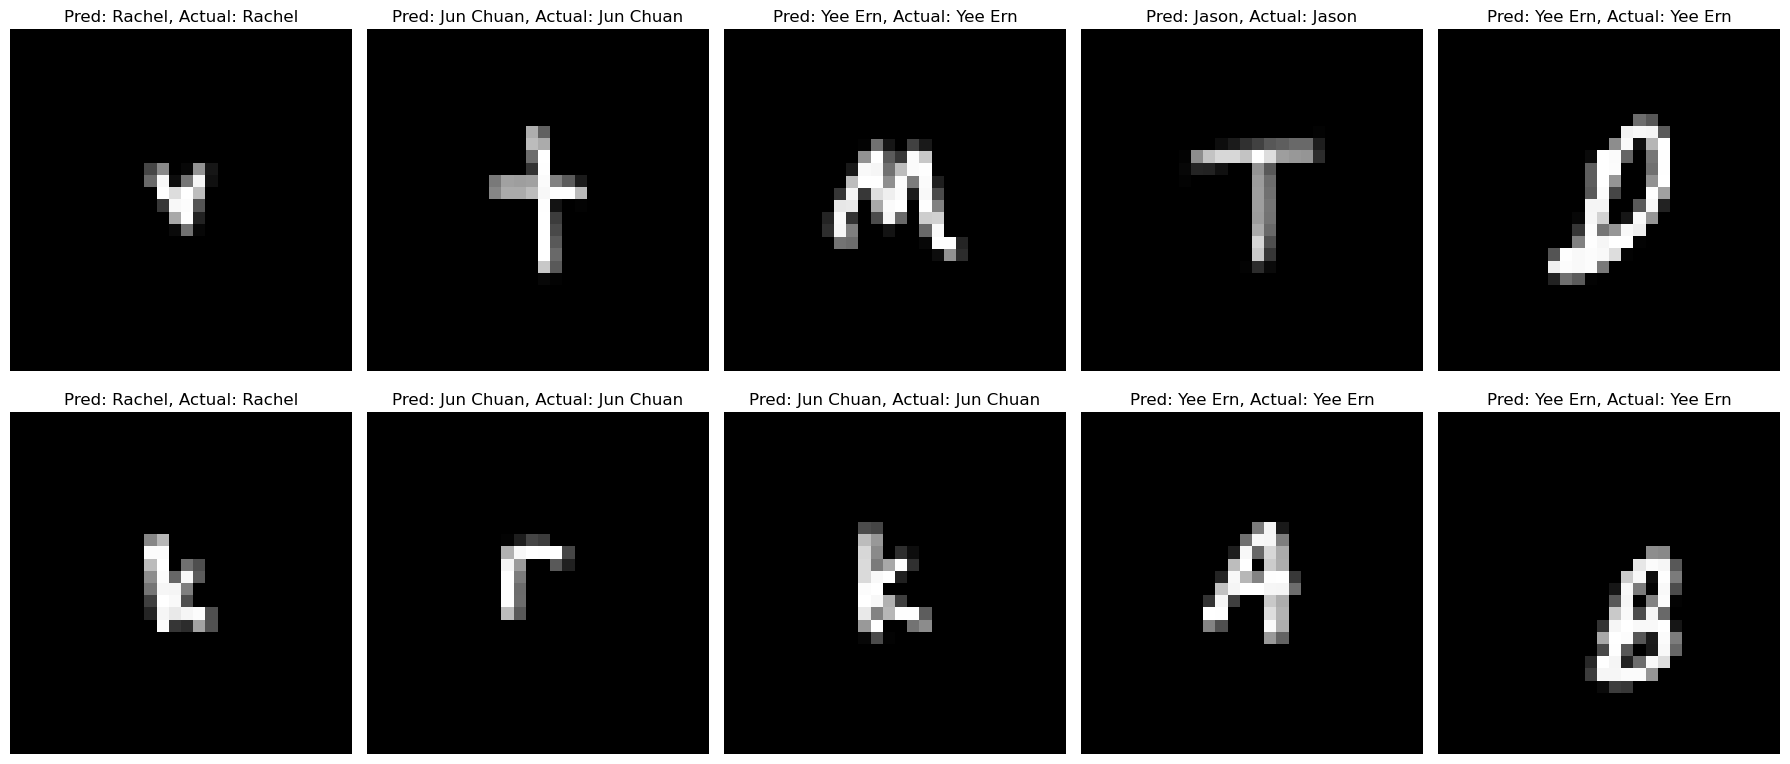

In [28]:
index_to_class = {i: class_label for i, class_label in enumerate(class_labels)}

# Convert y_test from one-hot encoded format to label format
y_test_labels = np.argmax(y_test, axis=1)

# Assuming X_images contains the original images corresponding to fuzzy_features
X_images_train, X_images_test, _, _ = train_test_split(binary_samples, classes, test_size=0.2, random_state=42)

# Display 10 examples of correct predictions
plt.figure(figsize=(18, 8))
for i, correct in enumerate(correct_indices[:10]):
    plt.subplot(2, 5, i+1)  # Adjusting subplot layout for 10 samples
    plt.imshow(X_images_test[correct], cmap='gray')
    plt.title(f"Pred: {index_to_class[y_pred[correct]]}, Actual: {index_to_class[y_test_labels[correct]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

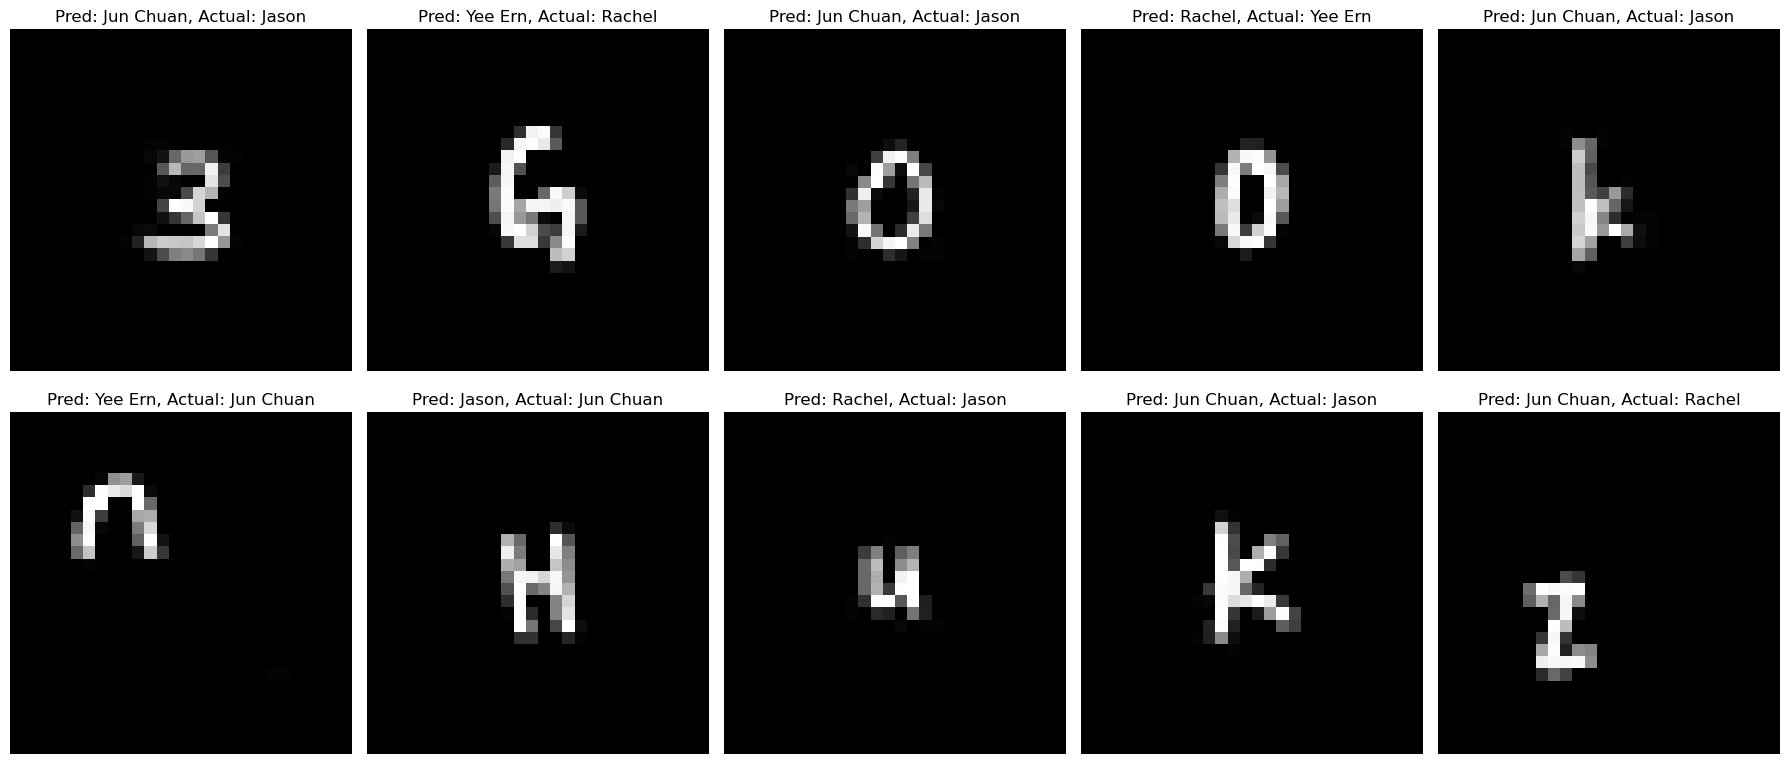

In [29]:
# Assuming X_images_test contains the original images
plt.figure(figsize=(18, 8))
for i, incorrect in enumerate(incorrect_indices[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_images_test[incorrect], cmap='gray')
    plt.title(f"Pred: {index_to_class[y_pred[incorrect]]}, Actual: {index_to_class[y_test_labels[incorrect]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 31ms/step


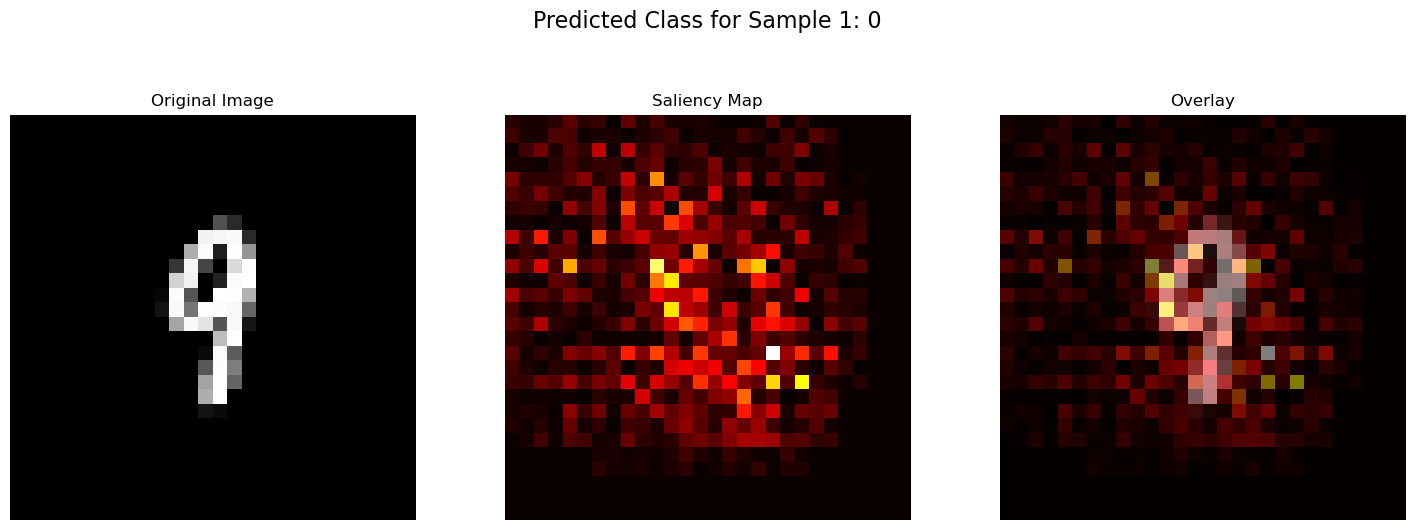

1/1 [==============================] - 0s 31ms/step


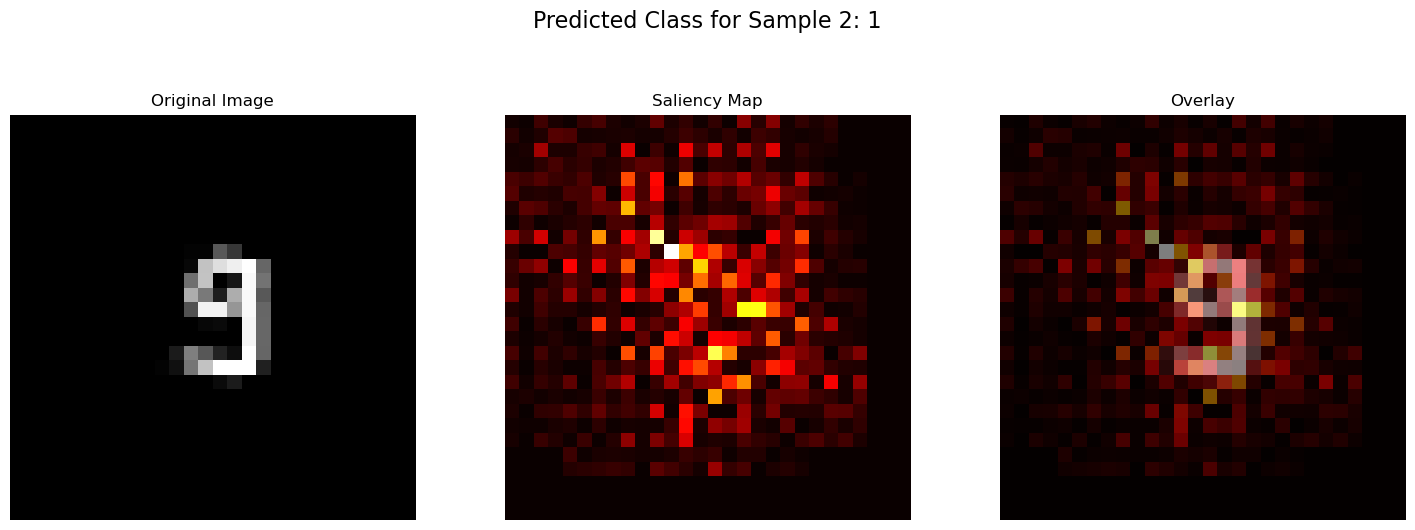

1/1 [==============================] - 0s 32ms/step


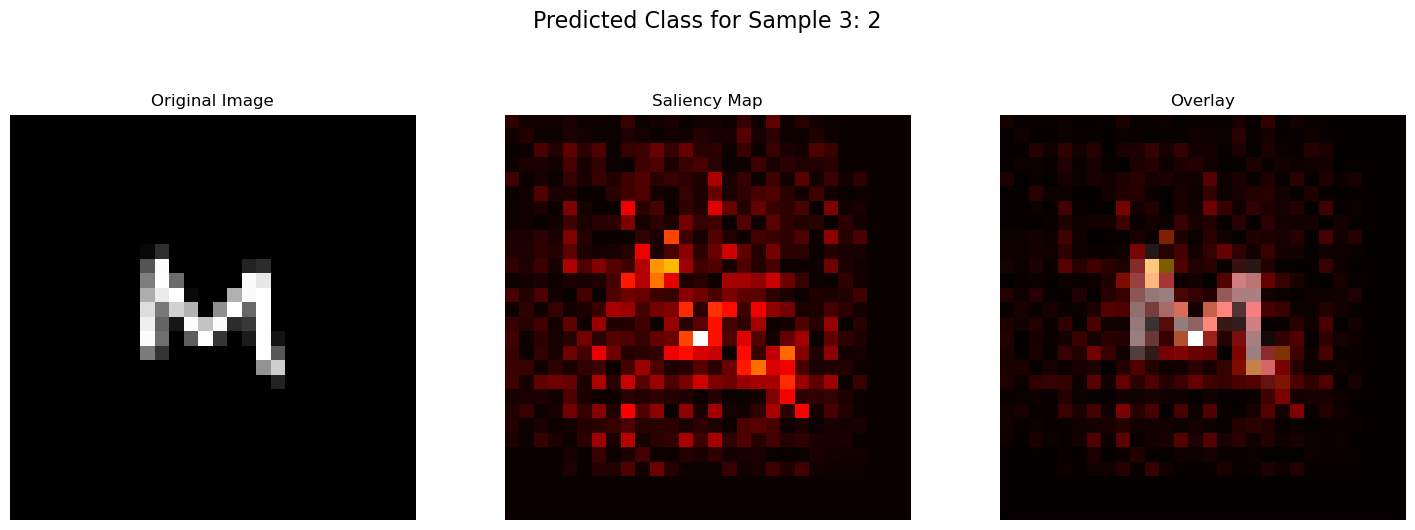

1/1 [==============================] - 0s 33ms/step


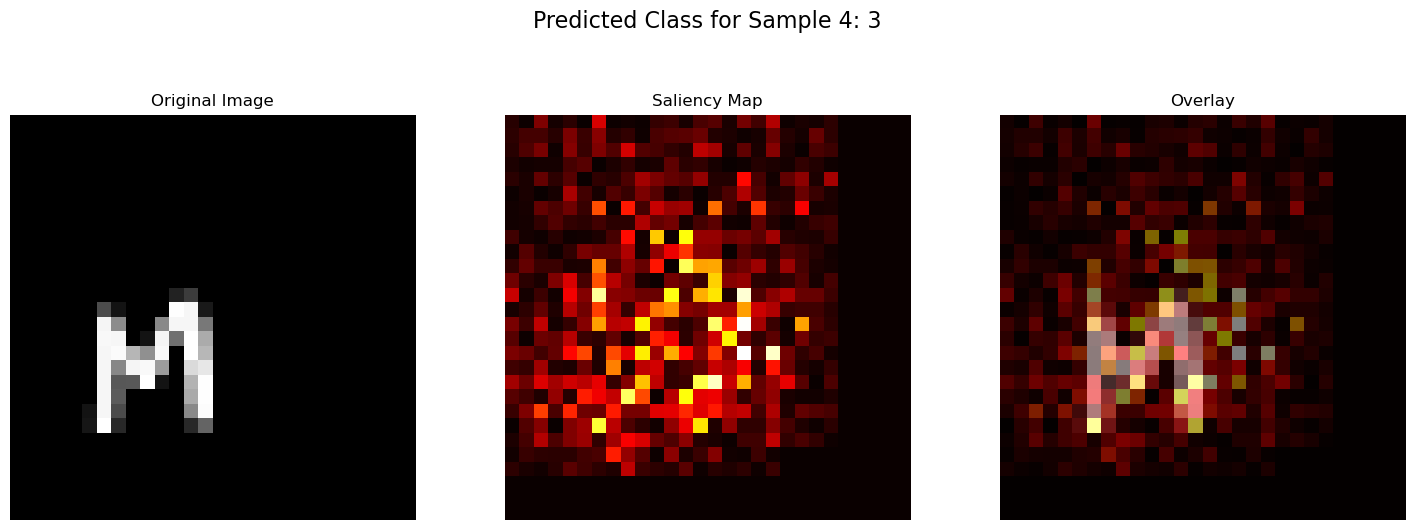

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_saliency_map(model, img, class_index):
    img_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, img_tensor)[0]
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))
    return saliency.numpy()

def visualize_saliency_map(img, saliency_map, predicted_class, confidence, sample_num):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Saliency Map')
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Overlay')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(saliency_map, cmap='hot', alpha=0.5)
    plt.axis('off')

    plt.suptitle(f'Predicted Class for Sample {sample_num}: {predicted_class}\n', y=1.05, fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
samples = [binary_samples[9], binary_samples[500],binary_samples[700],binary_samples[1000]]  # Add more samples if needed
for i, sample_image in enumerate(samples, start=1):
    prediction = best_model.predict(np.expand_dims(sample_image, axis=0))
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    saliency_map = compute_saliency_map(best_model, sample_image, predicted_class)
    visualize_saliency_map(sample_image, saliency_map, predicted_class, confidence, i)
